# Swire Coca-Cola Capstone Modeling
### Group 6: Darren Black, Chris Mcteague, and Sam Robinson
### IS 6813
### 11/3/2024

# Business Problem Statement

Swire Coca Cola experiences a loss of approximately 60 million dollars a year due to machine down times annually. Currently workers are deployed in a reactive fashion to fix the broken machines but this is a slow process that limits productivity. A solution to this problem would be implementing a predictive model that could alert workers of machines with a high probability of malfunctioning prior to the incident itself thus reducing the time the machine is down and increasing productivity.

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import missingno as msno
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from lifelines import KaplanMeierFitter
from lifelines.utils import concordance_index

## Data Cleaning

Before we can begin modeling, it's essential to clean and prepare the dataset to ensure it is suitable for our predictive goal. As outlined in our exploratory data analysis (EDA), this process involves handling missing values and restructuring the data to align with our target variable—predicting the time to failure of Swire Coca-Cola’s manufacturing machines. Key steps will include addressing incomplete or inconsistent data, transforming variables as needed, and selecting relevant features to enhance model accuracy and interpretability. Proper data preparation will help ensure the modeling process yields meaningful and actionable insights.

We will start by handling missing values.

In [ ]:
df = pd.read_csv(r"/content/IWC_Work_Orders_Extract.csv", low_memory=False)

<Axes: >

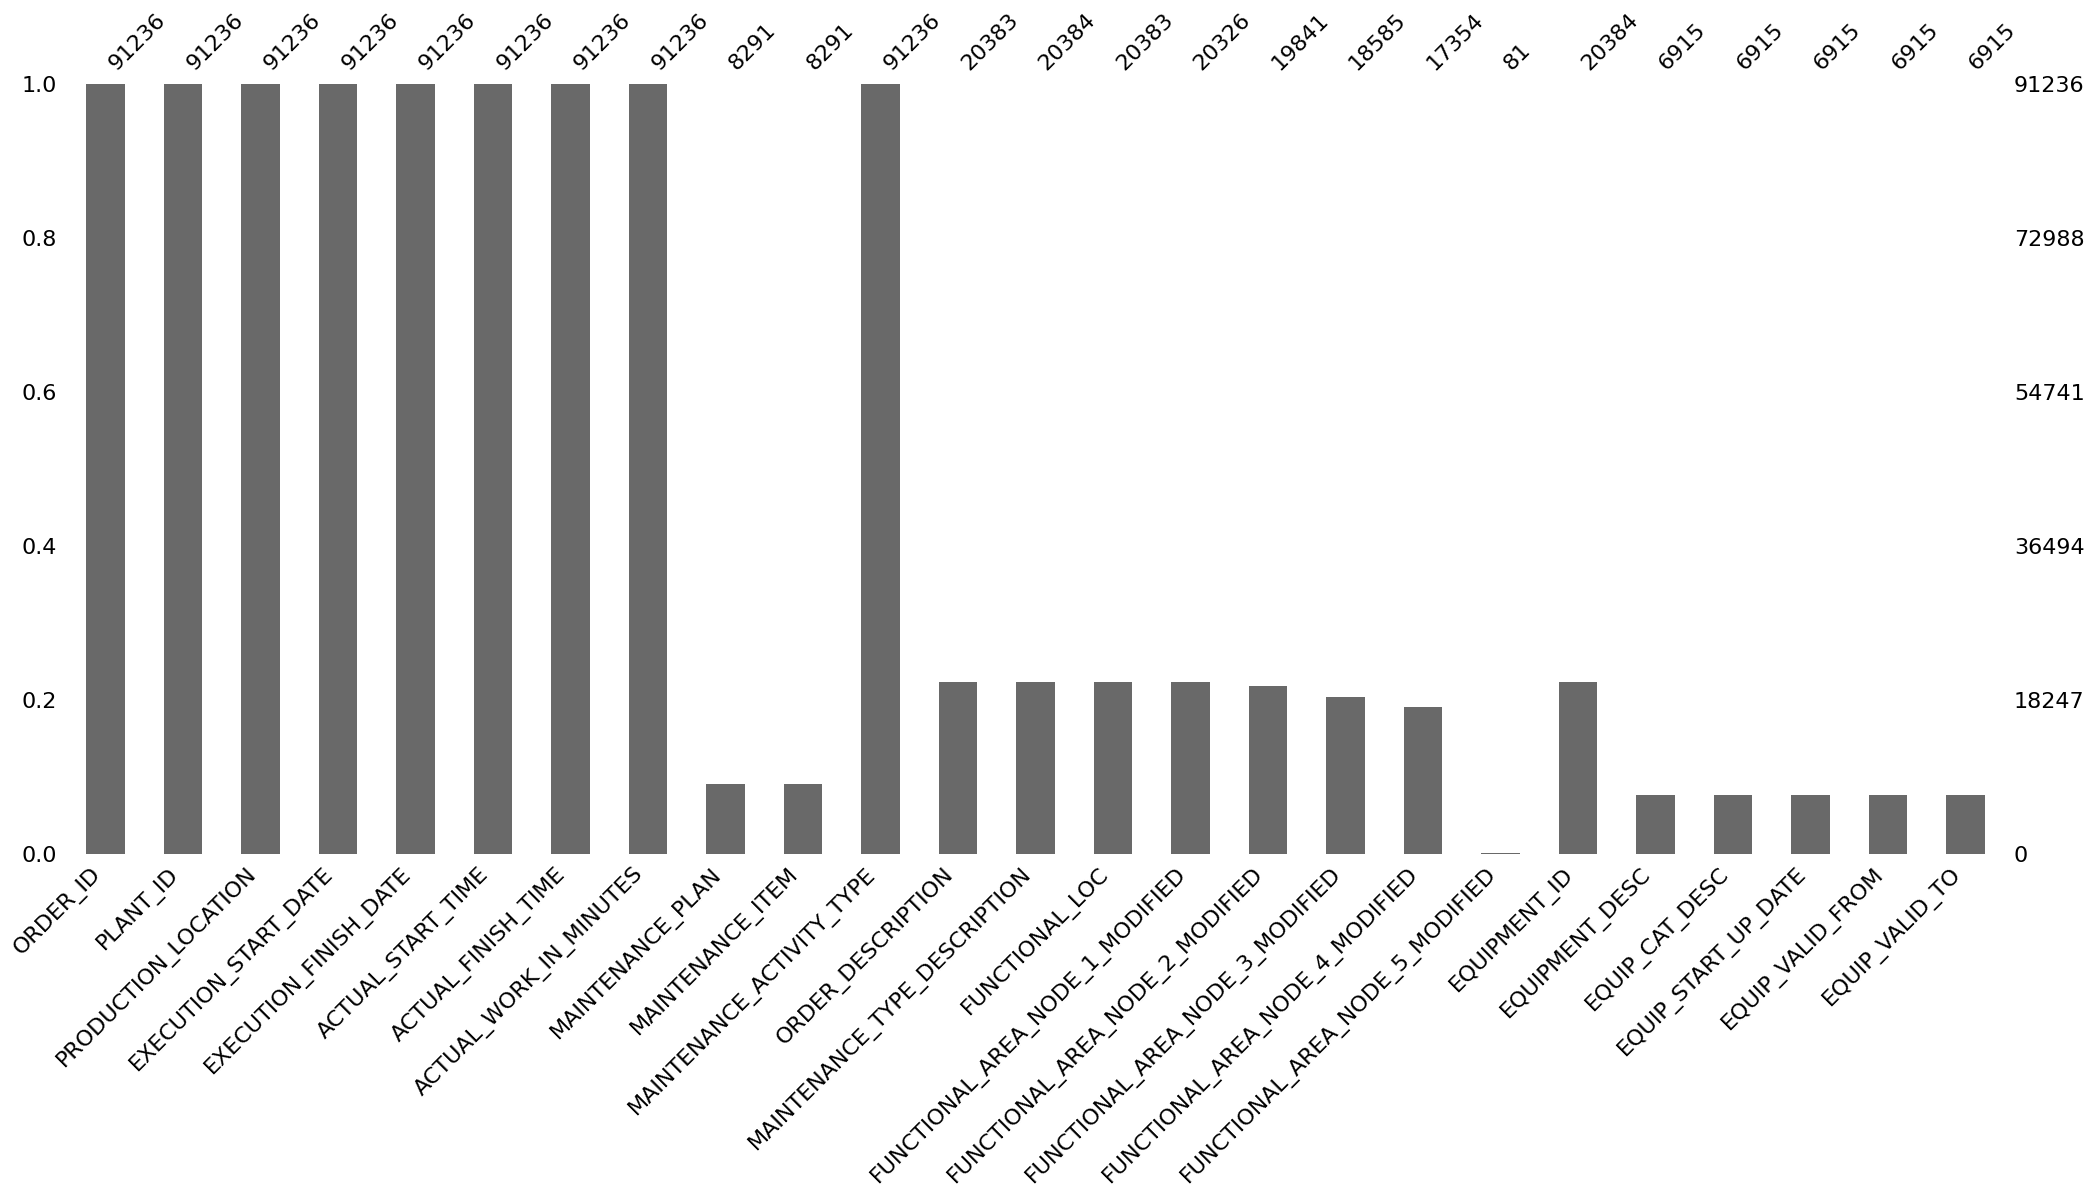

In [ ]:
msno.bar(df)

The graph above illustrates the proportion of non-null values compared to the total number of rows in the dataset. It’s evident that a large portion of our data is missing, with only a few features having more than 20% of their values filled. This presents a significant challenge, as imputing the remaining 80% of data with any level of accuracy would be highly unreliable.

To address this, we will focus on a subset of the data where at least 20% of the values are present and use this portion to construct our model. While this limits the dataset’s size, we hope this subset will provide a sufficiently representative sample to allow for meaningful analysis, even with the missing data.

Given these limitations, to generate our target variable—the "time to failure" column—we will calculate the time between occurrences of unplanned maintenance warnings for each machine. However, since the 'Functional_LOC' (the IP address or identifier for individual machines) is only 20% filled, we will proceed with this subset for analysis. Although not ideal, this approach allows us to work with the available data while acknowledging its limitations.

In [ ]:
df = df[df['FUNCTIONAL_LOC'].isna() == False]

<Axes: >

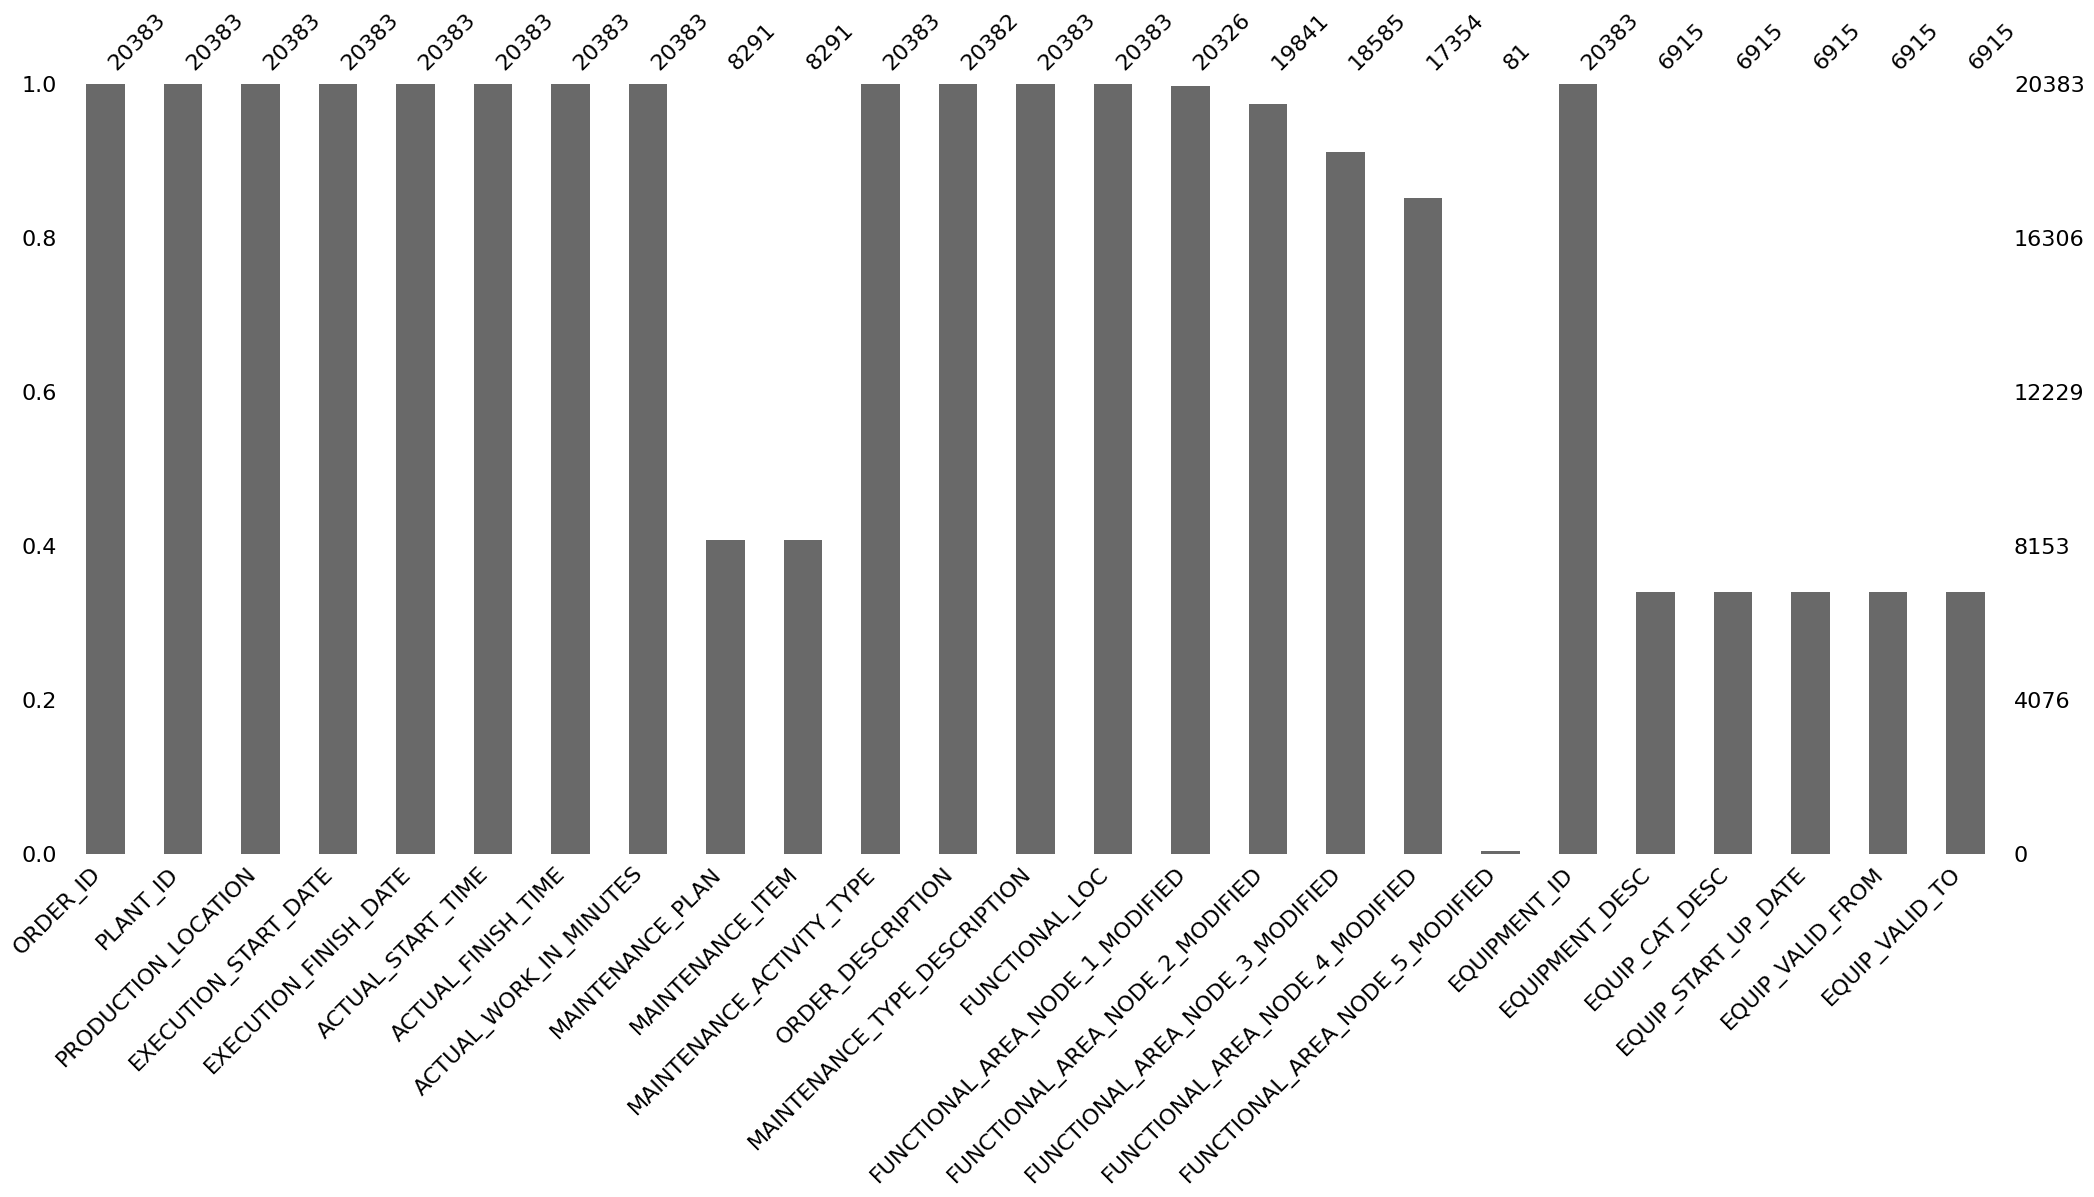

In [ ]:
msno.bar(df)

Next, we will further refine the dataset through several key steps:

Filling Missing EQUIP_START_UP_DATE Values: We will fill any missing EQUIP_START_UP_DATE values by leveraging the existing dates within the corresponding FUNCTIONAL_LOC machine groups. This ensures that each machine has a complete EQUIP_START_UP_DATE where possible.

Converting Date Columns to Datetime: We will convert all relevant date columns, such as EXECUTION_START_DATE and ACTUAL_START_TIME, to proper datetime datatypes to facilitate easier time-based calculations and ensure consistency throughout the dataset.

Splitting the FUNCTIONAL_LOC Column: The FUNCTIONAL_LOC column, which can contain up to six segments, will be separated into individual components. This will enable more granular data processing and feature engineering in future steps.

Sorting the Dataset: Finally, the dataset will be arranged in ascending order based on FUNCTIONAL_LOC, EXECUTION_START_DATE, and ACTUAL_START_TIME. This will ensure chronological ordering within each machine group, which is critical for calculating time-to-failure and other time-based metrics.

In [ ]:
#filling in missing 'EQUIP_START_UP_DATE' values that already have a corresponding value based on 'FUNCTIONAL_LOC'
df['EQUIP_START_UP_DATE'] = df.groupby('FUNCTIONAL_LOC')['EQUIP_START_UP_DATE'].transform(lambda group: group.ffill().bfill())
#transforming date columns into datetime datatype
df['EQUIP_START_UP_DATE'] = pd.to_datetime(df['EQUIP_START_UP_DATE'], errors='coerce')
df['EXECUTION_START_DATE'] = pd.to_datetime(df['EXECUTION_START_DATE'])
#creating a year column
df['YEAR'] = df['EXECUTION_START_DATE'].dt.year
#seperating out 'FUNCTIONAL_LOC'
df[['SEGMENT_1', 'SEGMENT_2', 'SEGMENT_3', 'SEGMENT_4', 'SEGMENT_5', 'SEGMENT_6']] = df['FUNCTIONAL_LOC'].str.split('-', expand=True, n=5)
#aranging dataset in ascending order of the below features
df = df.sort_values(by=['FUNCTIONAL_LOC','EXECUTION_START_DATE','ACTUAL_START_TIME'], ascending=[True,True,True])

<ipython-input-74-0ad841e9c39f>:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['EQUIP_START_UP_DATE'] = df.groupby('FUNCTIONAL_LOC')['EQUIP_START_UP_DATE'].transform(lambda group: group.ffill().bfill())


In [ ]:
df.head(10)

,ORDER_ID,PLANT_ID,PRODUCTION_LOCATION,EXECUTION_START_DATE,EXECUTION_FINISH_DATE,ACTUAL_START_TIME,ACTUAL_FINISH_TIME,ACTUAL_WORK_IN_MINUTES,MAINTENANCE_PLAN,MAINTENANCE_ITEM,...,EQUIP_START_UP_DATE,EQUIP_VALID_FROM,EQUIP_VALID_TO,YEAR,SEGMENT_1,SEGMENT_2,SEGMENT_3,SEGMENT_4,SEGMENT_5,SEGMENT_6
85107,700039229,G221,SUZUKA,2017-05-08,2017-05-08,06:00:00.000,06:00:00.000,15.0,G22121244,90361.0,...,NaT,NaN,NaN,2017,G221,CLR,A85,E06,None,None
42350,700042766,G221,SUZUKA,2017-05-18,2017-05-18,06:00:00.000,06:00:00.000,15.0,G22121244,90361.0,...,NaT,NaN,NaN,2017,G221,CLR,A85,E06,None,None
42348,700055148,G221,SUZUKA,2017-06-01,2017-06-01,06:00:00.000,12:00:00.000,27.0,G221VJ5041,90386.0,...,NaT,NaN,NaN,2017,G221,CLR,A85,E06,None,None
89713,700049617,G221,SUZUKA,2017-06-09,2017-06-09,06:00:00.000,06:00:00.000,30.0,G22121243,90823.0,...,NaT,NaN,NaN,2017,G221,CLR,A85,E06,None,None
42837,700055142,G221,SUZUKA,2017-06-15,2017-06-15,06:00:00.000,06:00:00.000,15.0,G22121244,90361.0,...,NaT,NaN,NaN,2017,G221,CLR,A85,E06,None,None
89708,700055143,G221,SUZUKA,2017-06-15,2017-06-15,06:00:00.000,06:00:00.000,15.0,G22121244,90362.0,...,NaT,NaN,NaN,2017,G221,CLR,A85,E06,None,None
47045,700065705,G221,SUZUKA,2017-06-20,2017-06-20,06:00:00.000,06:00:00.000,15.0,G22121243,90823.0,...,NaT,NaN,NaN,2017,G221,CLR,A85,E06,None,None
42833,700071347,G221,SUZUKA,2017-06-30,2017-06-30,06:00:00.000,12:00:00.000,51.0,G22121242,90360.0,...,NaT,NaN,NaN,2017,G221,CLR,A85,E06,None,None
47020,700077201,G221,SUZUKA,2017-07-12,2017-07-12,06:00:00.000,06:00:00.000,30.0,G22121243,90823.0,...,NaT,NaN,NaN,2017,G221,CLR,A85,E06,None,None
89723,700088116,G221,SUZUKA,2017-07-26,2017-07-26,07:00:00.000,14:00:00.000,30.0,G22121242,90359.0,...,NaT,NaN,NaN,2017,G221,CLR,A85,E06,None,None


## Data Processing

Now that our data is properly arranged and we've addressed some of the null values, we can move forward with creating calculated fields that will enhance our model. Additionally, we'll use interpolation to fill in missing values for critical fields, ensuring that our dataset is as complete as possible.

First, we will calculate the 'Time_To_Failure' for each machine, which will serve as our target variable. This calculation will involve determining the time between each breakdown event by looking forward in time.

After computing the 'Time_To_Failure' values, we will address any remaining missing values by filling them with the average time to failure for each respective machine.

In [ ]:
#clean 'ACTUAL_START_TIME' by removing milliseconds (if they exist) and convert to datetime time format
df['ACTUAL_START_TIME'] = pd.to_datetime(df['ACTUAL_START_TIME'].str.split('.').str[0], format='%H:%M:%S').dt.time

#combine 'EXECUTION_START_DATE' and 'ACTUAL_START_TIME' into a single datetime column
df['Maintenance_Start_Datetime'] = pd.to_datetime(df['EXECUTION_START_DATE'].astype(str) + ' ' + df['ACTUAL_START_TIME'].astype(str))

#sort the DataFrame by 'FUNCTIONAL_LOC' and 'Maintenance_Start_Datetime'
df = df.sort_values(by=['FUNCTIONAL_LOC', 'Maintenance_Start_Datetime'], ascending=[True, True])

#create a new column to store the time until the next unplanned maintenance
df['Time_To_Failure'] = None

#loop through each machine group
for loc, group in df.groupby('FUNCTIONAL_LOC'):
    #create a variable to track the next unplanned maintenance date
    next_unplanned_date = None

    #loop over the rows in this group
    for idx in reversed(group.index):
        row = df.loc[idx]

        #if the row represents an "Unplanned" maintenance update next_unplanned_date
        if row['MAINTENANCE_ACTIVITY_TYPE'] == 'Unplanned':
            if next_unplanned_date is not None:
                #calculate the time until the next unplanned maintenance
                time_to_failure = (next_unplanned_date - row['Maintenance_Start_Datetime']).days
                df.at[idx, 'Time_To_Failure'] = time_to_failure
            next_unplanned_date = row['Maintenance_Start_Datetime']
        else:
            #for planned maintenance, calculate the time until the next unplanned maintenance
            if next_unplanned_date is not None:
                time_to_failure = (next_unplanned_date - row['Maintenance_Start_Datetime']).days
                df.at[idx, 'Time_To_Failure'] = time_to_failure

#convert the new column into a integer
df['Time_To_Failure'] = pd.to_numeric(df['Time_To_Failure'], errors='coerce').astype('Int64')

In [ ]:
#filter for missing values
df_filtered = df[df['Time_To_Failure'].isna() == False]
#find the mean of 'Time_To_Failure' for each machine group
overall_mean = df_filtered['Time_To_Failure'].mean()
#round it into an integer
overall_mean = overall_mean.round()
#fill in missing values
df['Time_To_Failure'].fillna(overall_mean, inplace=True)

<ipython-input-76-8b1798d1beb4>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Time_To_Failure'].fillna(overall_mean, inplace=True)


Next, we will calculate the 'Days_Since_Planned_Maintenance' for each machine. This will involve using the provided date stamps to determine the number of days that have elapsed since each machine received planned maintenance.By calculating this metric, we can gain insights into how maintenance schedules may impact potential failure rates.  

In [ ]:
#create a new column to store the days since last planned maintenance
df['Days_Since_Planned_Maintenance'] = None

#loop through each machine group
for loc, group in df.groupby('FUNCTIONAL_LOC'):
    #track the last planned maintenance date
    last_planned_date = None

    #loop over the rows in this group
    for idx, row in group.iterrows():
        #if the row represents a "Planned" maintenance, update last_planned_date
        if row['MAINTENANCE_ACTIVITY_TYPE'] == 'Planned':
            last_planned_date = row['Maintenance_Start_Datetime']
            df.at[idx, 'Days_Since_Planned_Maintenance'] = 0  #set to 0 on the day of planned maintenance
        else:
            #for non-planned maintenance, calculate days since the last planned maintenance
            if last_planned_date is not None:
                days_since = (row['Maintenance_Start_Datetime'] - last_planned_date).days
                df.at[idx, 'Days_Since_Planned_Maintenance'] = days_since

#convert the new column to integer
df['Days_Since_Planned_Maintenance'] = pd.to_numeric(df['Days_Since_Planned_Maintenance'], errors='coerce').astype('Int64')

In [ ]:
#filter for missing values
df_filtered = df[df['Days_Since_Planned_Maintenance'].isna() == False]
#find the mean of 'Days_Since_Planned_Maintenance' for each machine group
overall_mean = df_filtered['Days_Since_Planned_Maintenance'].mean()
#round it into an integer
overall_mean = overall_mean.round()
#fill in missing values
df['Days_Since_Planned_Maintenance'].fillna(overall_mean, inplace=True)

<ipython-input-78-7e156699be0c>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Days_Since_Planned_Maintenance'].fillna(overall_mean, inplace=True)


With the 'Time_To_Failure' and 'Days_Since_Planned_Maintenance' fields created, we can proceed to calculate additional metrics that assess the frequency of both unplanned and planned maintenance events over the past month, six months, and year. While these metrics are likely to be highly correlated with one another, we will focus on retaining those that demonstrate the most significant impact on our model's performance. This approach will help streamline our feature set while ensuring we capture the essential influences on machine reliability and failure predictions.

In [ ]:
#create a binary flag for "Unplanned" maintenance
df['Unplanned_Flag'] = (df['MAINTENANCE_ACTIVITY_TYPE'] == 'Unplanned').astype(int)

#convert 'EXECUTION_START_DATE' to datetime if it's not already
df['EXECUTION_START_DATE'] = pd.to_datetime(df['EXECUTION_START_DATE'])

#sort the DataFrame by 'FUNCTIONAL_LOC' and 'EXECUTION_START_DATE'
df = df.sort_values(by=['FUNCTIONAL_LOC', 'EXECUTION_START_DATE'], ascending=[True, True])

#define a rolling window function
def calculate_rolling_unplanned(df, window_size):
    return df.groupby('FUNCTIONAL_LOC')['Unplanned_Flag'].rolling(window=window_size, min_periods=1).sum().reset_index(level=0, drop=True)

#calculate rolling sums for different time windows
days_in_month = 30

df['Unplanned_Rolling_12M'] = calculate_rolling_unplanned(df, window_size=12 * days_in_month)
df['Unplanned_Rolling_6M'] = calculate_rolling_unplanned(df, window_size=6 * days_in_month)
df['Unplanned_Rolling_1M'] = calculate_rolling_unplanned(df, window_size=1 * days_in_month)

In [ ]:
#create a binary flag for "Planned" maintenance
df['Planned_Flag'] = (df['MAINTENANCE_ACTIVITY_TYPE'] == 'Planned').astype(int)

#convert 'EXECUTION_START_DATE' to datetime if it's not already
df['EXECUTION_START_DATE'] = pd.to_datetime(df['EXECUTION_START_DATE'])

#sort the DataFrame by 'FUNCTIONAL_LOC' and 'EXECUTION_START_DATE'
df = df.sort_values(by=['FUNCTIONAL_LOC', 'EXECUTION_START_DATE'], ascending=[True, True])

#define a rolling window function
def calculate_rolling_unplanned(df, window_size):
    return df.groupby('FUNCTIONAL_LOC')['Planned_Flag'].rolling(window=window_size, min_periods=1).sum().reset_index(level=0, drop=True)

#calculate rolling sums for different time windows
days_in_month = 30

df['Planned_Rolling_12M'] = calculate_rolling_unplanned(df, window_size=12 * days_in_month)
df['Planned_Rolling_6M'] = calculate_rolling_unplanned(df, window_size=6 * days_in_month)
df['Planned_Rolling_1M'] = calculate_rolling_unplanned(df, window_size=1 * days_in_month)

Another potentially important field to consider is the number of times a specific piece of equipment has been replaced within a given machine over time. This metric could provide valuable insights into both the frequency of part replacements and the likelihood of future breakdowns, which may in turn lead to machine failure. By tracking how often critical components are replaced, we can better understand wear patterns and identify when a machine is at higher risk of failure due to part degradation or repeated issues.

In [ ]:
#create a binary flag for each equipment occurrence
df['Equipment_Occurrence_Flag'] = 1

#group by 'FUNCTIONAL_LOC' and 'EQUIPMENT_ID', perform cumulative sum to get rolling count
df['Cumulative_Equipment_Replacements'] = df.groupby(['FUNCTIONAL_LOC', 'EQUIPMENT_ID'])['Equipment_Occurrence_Flag'].cumsum()

# Feature Selection

Now that we have added several new features, the next step is to assess whether any of them are correlated with our target variable, time to failure. By examining the correlation matrix below, we can see that both the number of planned and unplanned maintenance events in the past month show a strong correlation with time to failure. This is a positive sign, as these features appear to be meaningful predictors.

Given this, we will remove other columns that are closely related to these two, as they may introduce redundancy without providing additional value to the model.

In [ ]:
X = df.drop(columns=['Equipment_Occurrence_Flag','YEAR','EQUIPMENT_DESC',	'EQUIP_CAT_DESC','EQUIP_START_UP_DATE',	'EQUIP_VALID_FROM',	'EQUIP_VALID_TO',
'FUNCTIONAL_LOC',	'FUNCTIONAL_AREA_NODE_1_MODIFIED',	'FUNCTIONAL_AREA_NODE_2_MODIFIED',	'FUNCTIONAL_AREA_NODE_3_MODIFIED',	'FUNCTIONAL_AREA_NODE_4_MODIFIED', 'FUNCTIONAL_AREA_NODE_5_MODIFIED',
'MAINTENANCE_ACTIVITY_TYPE',	'ORDER_DESCRIPTION',	'MAINTENANCE_TYPE_DESCRIPTION','MAINTENANCE_PLAN','ORDER_ID',	'PLANT_ID',	'PRODUCTION_LOCATION',	'EXECUTION_START_DATE',	'EXECUTION_FINISH_DATE',
'ACTUAL_START_TIME',	'ACTUAL_FINISH_TIME',	'SEGMENT_1',	'SEGMENT_2',	'SEGMENT_3',	'SEGMENT_4',	'SEGMENT_5',	'SEGMENT_6'])

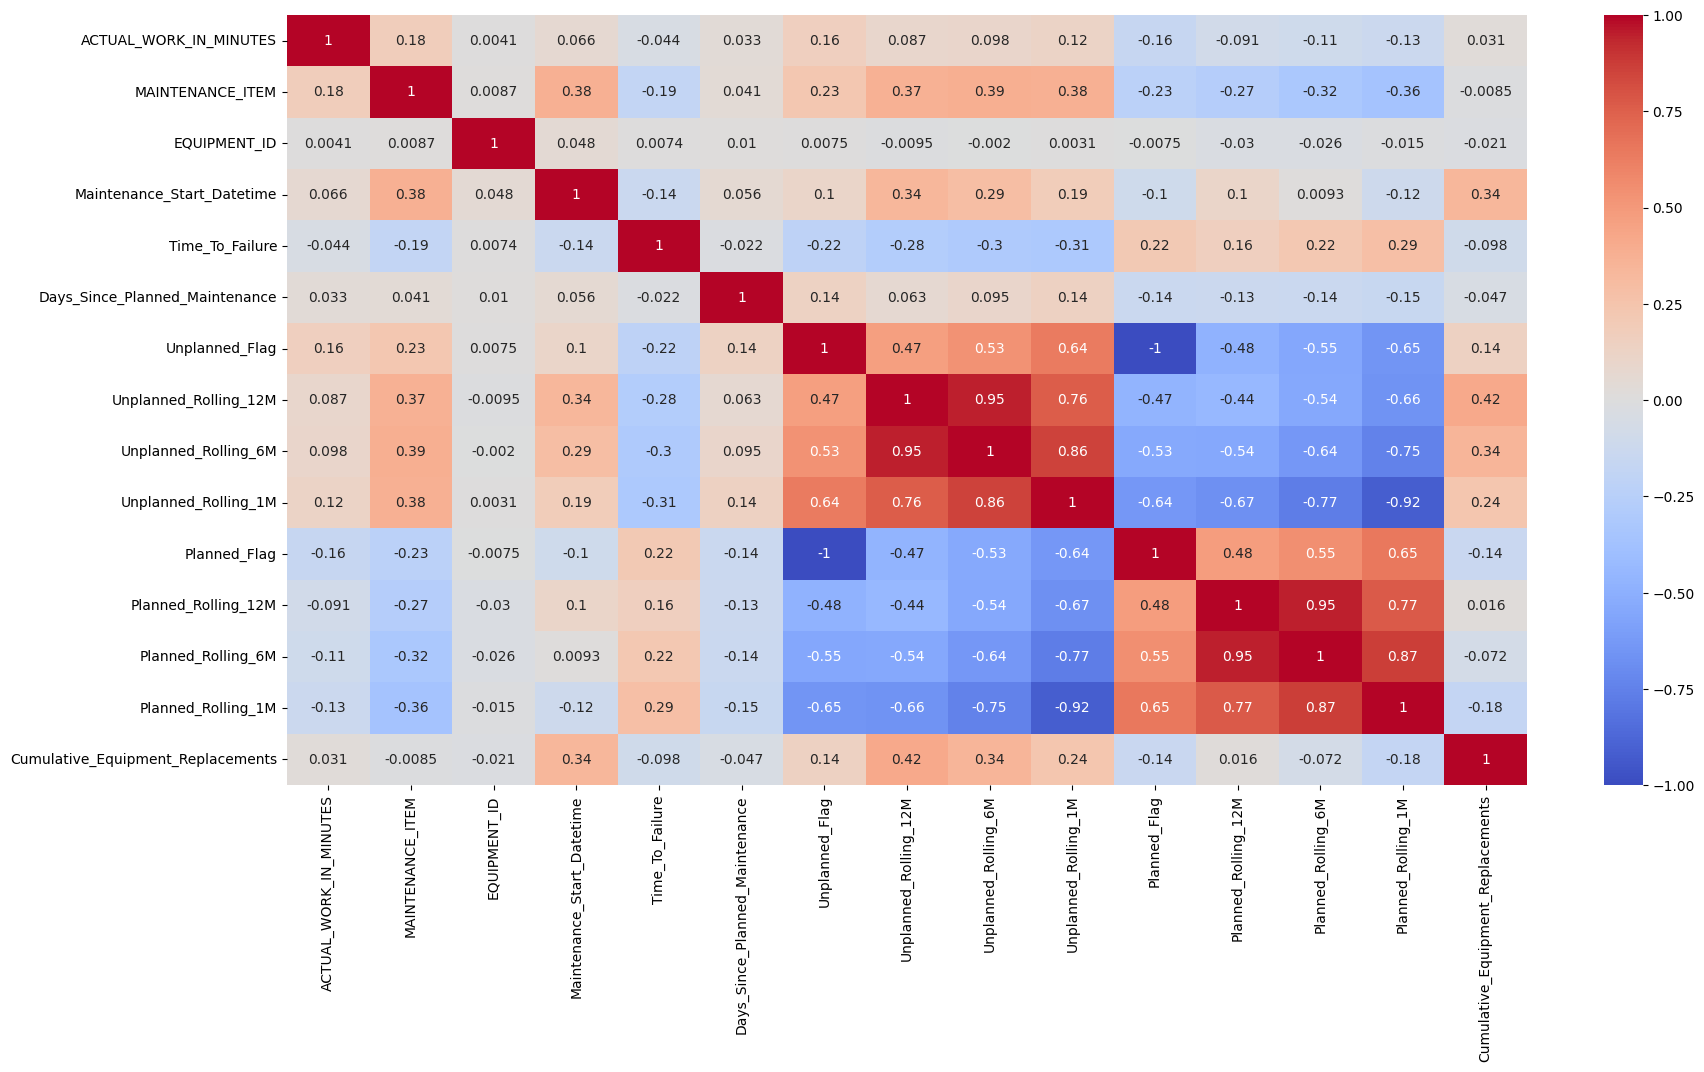

In [ ]:
corr_matrix = X.corr()
plt.figure(figsize=(20, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

In [ ]:
df = df.drop(columns=['Unplanned_Rolling_12M',	'Unplanned_Rolling_6M','Planned_Rolling_12M',	'Planned_Rolling_6M','Equipment_Occurrence_Flag','Unplanned_Flag','Planned_Flag','YEAR'])

# ML Implementation

## Survival Model

In [ ]:
# seperate data sets into planned and unplanned
df_unplanned = df[df['MAINTENANCE_ACTIVITY_TYPE']=='Unplanned']
df_planned = df[df['MAINTENANCE_ACTIVITY_TYPE']=='Planned']
df_unplanned = df_unplanned[df_unplanned['Time_To_Failure'] != 0]
df_unplanned.head()

,ORDER_ID,PLANT_ID,PRODUCTION_LOCATION,EXECUTION_START_DATE,EXECUTION_FINISH_DATE,ACTUAL_START_TIME,ACTUAL_FINISH_TIME,ACTUAL_WORK_IN_MINUTES,MAINTENANCE_PLAN,MAINTENANCE_ITEM,...,SEGMENT_3,SEGMENT_4,SEGMENT_5,SEGMENT_6,Maintenance_Start_Datetime,Time_To_Failure,Days_Since_Planned_Maintenance,Unplanned_Rolling_1M,Planned_Rolling_1M,Cumulative_Equipment_Replacements
85949,701271251,G221,SUZUKA,2019-03-19,2019-03-19,07:00:00,07:00:00.000,480.0,NaN,NaN,...,None,None,None,None,2019-03-19 07:00:00,8,43,1.0,0.0,1
85950,701288992,G221,SUZUKA,2019-03-27,2019-03-27,07:00:00,07:00:00.000,69.6,NaN,NaN,...,None,None,None,None,2019-03-27 07:00:00,1743,43,2.0,0.0,2
48141,705346923,G221,SUZUKA,2024-01-03,2024-01-03,08:00:00,08:00:00.000,240.0,NaN,NaN,...,None,None,None,None,2024-01-03 08:00:00,141,43,3.0,0.0,1
48142,705694076,G221,SUZUKA,2024-05-24,2024-05-24,07:00:00,07:00:00.000,60.0,NaN,NaN,...,None,None,None,None,2024-05-24 07:00:00,99,43,4.0,0.0,2
88391,702467001,G221,SUZUKA,2020-09-16,2020-09-16,07:00:00,07:00:00.000,420.0,NaN,NaN,...,A99,L06,0001,None,2020-09-16 07:00:00,37,159,1.0,1.0,2


In [ ]:
df_unplanned['event'] = 1
df_unplanned['time'] = df_unplanned['Time_To_Failure']
kmf = KaplanMeierFitter()

# Create an empty list to store results
results = []

# Group by FUNCTIONAL LOC and EQUIPMENT ID
groups = df_unplanned.groupby(['FUNCTIONAL_LOC','EQUIPMENT_ID'])

for (loc, equip), group in groups:
    # Fit the model
    kmf.fit(group['time'], event_observed=group['event'])

    # Get survival function
    survival_function = kmf.survival_function_

    # Create a DataFrame with results
    for time, prob in survival_function.iterrows():
        results.append({
            'FUNCTIONAL_LOC': loc,
            'EQUIPMENT_ID': equip,
            'time': time,
            'predicted_lifespan': prob.values[0]
        })

# Convert the results list to a DataFrame
equiploc_results_df = pd.DataFrame(results)

# Optionally, pivot the DataFrame if you want to have times as columns
results_df_pivot = equiploc_results_df.pivot_table(index='FUNCTIONAL_LOC',
                                             columns='time',
                                             values='predicted_lifespan').reset_index()

# Display the results
print(equiploc_results_df.head())

  FUNCTIONAL_LOC  EQUIPMENT_ID    time  predicted_lifespan
0       G221-PRD   300009149.0     0.0                 1.0
1       G221-PRD   300009149.0     8.0                 0.5
2       G221-PRD   300009149.0  1743.0                 0.0
3       G221-PRD   300245200.0     0.0                 1.0
4       G221-PRD   300245200.0    99.0                 0.5


In [ ]:
c_index = concordance_index(equiploc_results_df['time'], -equiploc_results_df['predicted_lifespan'])
print("Concordance Index:", c_index)

Concordance Index: 0.8187992550599482


In [ ]:
df_unplanned['event'] = 1
df_unplanned['time'] = df_unplanned['Time_To_Failure']
kmf = KaplanMeierFitter()

# Create an empty list to store results
results = []

# Group by FUNCTIONAL LOC and EQUIPMENT ID
groups = df_unplanned.groupby('FUNCTIONAL_LOC')

for (loc), group in groups:
    # Fit the model
    kmf.fit(group['time'], event_observed=group['event'])

    # Get survival function
    survival_function = kmf.survival_function_

    # Create a DataFrame with results
    for time, prob in survival_function.iterrows():
        results.append({
            'FUNCTIONAL_LOC': loc,
            'time': time,
            'predicted_lifespan': prob.values[0]
        })

# Convert the results list to a DataFrame
functloc_results_df = pd.DataFrame(results)

# Optionally, pivot the DataFrame if you want to have times as columns
results_df_pivot = functloc_results_df.pivot_table(index='FUNCTIONAL_LOC',
                                             columns='time',
                                             values='predicted_lifespan').reset_index()

# Display the results
print(functloc_results_df.head())

  FUNCTIONAL_LOC    time  predicted_lifespan
0       G221-PRD     0.0                1.00
1       G221-PRD     8.0                0.75
2       G221-PRD    99.0                0.50
3       G221-PRD   141.0                0.25
4       G221-PRD  1743.0                0.00


In [ ]:
c_index2 = concordance_index(functloc_results_df['time'], -functloc_results_df['predicted_lifespan'])
print("Concordance Index:", c_index2)

Concordance Index: 0.8102169047676268


# Conclusion

In conclusion, there was a number of different attempts made to expand upon the data that we have access to via various methods, from machine learning techniques to data manipulation. Ultimately, we determined the best course of action would be to use the section of data that was the most complete, and attempt to extract information of value from that, which we believe we succesfully did.

While our model's were not super successfull due to the overall lack of data we believe that should Swire Coca-Cola be able to fill in these gaps in the future and add additional features, more precise modeling could be successful. At this point in time, Survival Analysis of Time to Failure for both individual machines, represented by FUNCTIONAL_LOC, as well as those machines and the more intricate pieces of them that required servicing, represented as EQUIPMENT_ID, appears to be promising. Two different Kaplan-Meier Fitter models were created, with one calculating the lifespan of individual pieces of equipment within specific machines, while the other simply represents the amount of time between unplanned maintenence events on various machines within the production system of Swire Coca-Cola. These models produced Concordance Index's of 0.82 and 0.81 respectively, indicating the models are doing a suprisingly adequate job of predicting the lifespan of these various pieces in the system. With further data collection, we believe these numbers could be drastically improved upon.  

One of the features that could be important to this analysis would be machine age. We attempt to create this field but were unsuccessfull due to the inconsitant machine start dates and other issues. Additional fields could include any live data that the plant's machines report such as tempurature, pressure or others. Another step we could have taken would be to try and interpulate more of the missing data. We filtered down to were we had good information about each machine's ID but we could have tried to fill in the missing 80%. That being said this would have been difficult because we have no way of knowing if we have all the possible Machine IDs (Functional Loc).